In [1]:
!pip install -qq einops

In [2]:
import warnings
warnings.filterwarnings('ignore')

import os
import time

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from einops import rearrange

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm
from glob import glob

seed = 42
pd.set_option('display.max_colwidth', None)

In [3]:
def seed_everything(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently using "{device.upper()}" device.')

Currently using "CUDA" device.


In [4]:
image_size = 224
drop_rate = 0.1
batch_size = 128

In [5]:
train_transforms = A.Compose([
                      A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, 
                                                    sat_shift_limit=0.2, 
                                                    val_shift_limit=0.2, 
                                                    p=0.1),      
                      A.RandomBrightnessContrast(brightness_limit=0.2, 
                                                 contrast_limit=0.2, 
                                                 p=0.5)],p=0.1),
                      A.OneOf(
                              [A.HorizontalFlip(p=0.5),
                               A.VerticalFlip(p=0.5),
                               A.RandomRotate90(p=0.5),
                               A.Transpose(p=0.5),
                              ], p=0.5),
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      A.Cutout(num_holes=6, max_h_size=10, max_w_size=10, fill_value=0, p=0.1),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

valid_transforms = A.Compose([
                      A.LongestMaxSize(max_size=image_size),
                      A.PadIfNeeded(min_height=image_size, min_width=image_size),
                      A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), max_pixel_value=255.0),
                      ToTensorV2(p=1.0),
                      ], p=1.0)

# inverse trasformations of a single image-tensor
def inverse_transforms(tensor):
    tensor = tensor 
    if tensor.size(0) == 1 and len(tensor.shape) == 4:
        tensor.squeeze_(0)
    tensor = torch.clamp(tensor * 0.5 + 0.5, min=0., max=1.)
    tensor = tensor.cpu().detach().numpy().transpose(1,2,0)

    return tensor

In [6]:
path = "/kaggle/input/weather-dataset/dataset/"

image_paths = glob(path + "*/*.jpg")
image_paths = [str(p) for p in image_paths]

labels = [p.split("/")[-2] for p in image_paths]
data = pd.DataFrame({"path": image_paths, "label": labels})

labels2int = {"dew": 0, "fogsmog": 1, "frost": 2, "glaze": 3, "hail": 4, "lightning": 5, "rain": 6, "rainbow": 7, "rime": 8, "sandstorm": 9, "snow": 10}
int2labels = {v: k for k, v in labels2int.items()}

data["label"] = data["label"].map(labels2int)

In [7]:
x_train, x_test = train_test_split(data, test_size=0.2, stratify=data["label"], random_state=seed)
x_valid, x_test = train_test_split(x_test, test_size=0.3, stratify=x_test["label"], random_state=seed)

x_train.reset_index(drop=True, inplace=True)
x_valid.reset_index(drop=True, inplace=True)
x_test.reset_index(drop=True, inplace=True)

print(f"train size: {len(x_train)}, valid size: {len(x_valid)}, test size: {len(x_test)}")

train size: 5489, valid size: 961, test size: 412


In [8]:
x_train["label"].value_counts(normalize=True)

8     0.169065
1     0.124066
0     0.101658
9     0.100747
3     0.093095
10    0.090545
4     0.086172
6     0.076699
2     0.069229
5     0.054837
7     0.033886
Name: label, dtype: float64

In [35]:
mins = []
for i in tqdm(range(len(data))):
    sz = Image.open(data["path"].iloc[i]).size
    if min(sz) < 224:
        mins.append(min(sz))
        
min(mins)  # ~12% of images < 224

  0%|          | 0/6862 [00:00<?, ?it/s]

91

In [9]:
class LayerNorm(nn.Module):
    def __init__(self, norm_dim, eps=1e-6, norm_type="channels_last"):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(norm_dim))
        self.bias = nn.Parameter(torch.zeros(norm_dim))
        self.eps = eps
        self.norm_type = norm_type
        self.norm_dim = (norm_dim, )
        
    def forward(self, x):
        if self.norm_type == "channels_last":
            return F.layer_norm(x, self.norm_dim, self.weight, self.bias, self.eps)
        elif self.norm_type == "channels_first":
            mu = x.mean(dim=1, keepdim=True)
            var = (x - mu).pow(2).mean(dim=1, keepdim=True)
            x = (x - mu) / torch.sqrt(var + self.eps)
            x = self.weight[:, None, None] * x + self.bias[:, None, None]
            return x
        
class GRN(nn.Module):
    def __init__(self, dim):
        super(GRN, self).__init__()
        self.gamma = nn.Parameter(torch.zeros(1, 1, 1, dim))
        self.beta = nn.Parameter(torch.zeros(1, 1, 1, dim))
        
    def forward(self, x):
        Gx = torch.linalg.norm(x, ord="fro", dim=(1, 2), keepdim=True)
        Nx = Gx / (Gx.mean(dim=-1, keepdim=True) + 1e-6)
        return self.gamma * (x * Nx) + self.beta + x

class ConvNextBlock(nn.Module):
    def __init__(self, dim, drop_rate=0.0):
        super(ConvNextBlock, self).__init__()
        self.down_conv = nn.Conv2d(in_channels=dim, out_channels=dim, kernel_size=7, stride=1, padding=3, groups=dim)  # depthwise convolution
        self.norm = LayerNorm(dim, eps=1e-6)
        self.pntwise_conv1 = nn.Linear(in_features=dim, out_features=dim * 4)
        self.activation = nn.GELU()
        self.grn = GRN(dim=dim * 4)
        self.pntwise_conv2 = nn.Linear(in_features=dim * 4, out_features=dim)
        self.drop_rate = drop_rate
    
    def _drop_connections(self, x):
        if not self.training:
            return x
        keep_probability = 1.0 - self.drop_rate
        batch_size = x.size(0)
        random_tensor = keep_probability + torch.rand(batch_size, 1, 1, 1, device=x.device)
        binary_tensor = random_tensor.floor()
        return x.div(keep_probability) * binary_tensor
    
    def forward(self, x):
        shortcut = x
        x = self.down_conv(x)
        x = rearrange(x, "b c h w -> b h w c")
        x = self.norm(x)
        x = self.activation(self.pntwise_conv1(x))
        x = self.grn(x)
        x = self.pntwise_conv2(x)
        x = rearrange(x, "b h w c -> b c h w")
        x = shortcut + self._drop_connections(x)
        return x
    
class ConvNext(nn.Module):
    def __init__(self, in_channels=3, num_classes=11, depths=[3, 3, 9, 3], dims=[96, 192, 384, 768], drop_path_rate=0.1, head_init_scale=1.0):  # set 0.001 in fine-tunning mode
        super(ConvNext, self).__init__()
        self.depths = depths
        self.downsample_layers = nn.ModuleList()
        stem = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=dims[0], kernel_size=4, stride=4, padding=0),
            LayerNorm(dims[0], eps=1e-6, norm_type="channels_first")
            )
        self.downsample_layers.append(stem)
        for i in range(3):
            downsample_layer = nn.Sequential(
                    LayerNorm(dims[i], eps=1e-6, norm_type="channels_first"),
                    nn.Conv2d(in_channels=dims[i], out_channels=dims[i+1], kernel_size=2, stride=2, padding=0)
                )
            self.downsample_layers.append(downsample_layer)
        self.stages = nn.ModuleList()
        drop_rates = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]
        current = 0
        for i in range(4):
            stage = nn.Sequential(
                    *[ConvNextBlock(dim=dims[i], drop_rate=drop_rates[current + j]) for j in range(depths[i])]
                )
            self.stages.append(stage)
            current += depths[i]
        self.norm = nn.LayerNorm(dims[-1], eps=1e-6)
        self.head = nn.Linear(in_features=dims[-1], out_features=num_classes)
        
        self.apply(self._init_weights)
        self.head.weight.data.mul_(head_init_scale)
        self.head.bias.data.mul_(head_init_scale)
        
    def _init_weights(self, m):
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            nn.init.trunc_normal_(m.weight, std=0.02)
            nn.init.constant_(m.bias, 0)
            
    def forward_features(self, x):
        for i in range(4):
            x = self.downsample_layers[i](x)
            x = self.stages[i](x)
        x = x.mean(dim=[2, 3])
        return self.norm(x)
    
    def forward(self, x):
        x = self.forward_features(x)
        x = self.head(x)
        return x

In [18]:
class WeatherDataset(Dataset):
    def __init__(self, data, transforms):
        self.data = data
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, ix):
        row = self.data.loc[ix].squeeze()
        image = Image.open(row["path"]).convert("RGB")
        image = np.array(image)
        
        sample = {"image": image}
        image = self.transforms(**sample)["image"]
        
        label = torch.as_tensor(row["label"], dtype=torch.int64)
        
        return image, label
    
    def collate_fn(self, batch):
        images, labels = list(zip(*batch))
        images, labels = [[tensor[None] for tensor in subset] for subset in (images, labels)]
        images, labels = [torch.cat(subset, dim=0).to(device) for subset in (images, labels)]
        return images, labels

In [19]:
train_ds = WeatherDataset(x_train, train_transforms)
valid_ds = WeatherDataset(x_valid, valid_transforms)
test_ds = WeatherDataset(x_test, valid_transforms)

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=train_ds.collate_fn)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, collate_fn=valid_ds.collate_fn)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=test_ds.collate_fn)

In [27]:
class EarlyStopping:
    def __init__(self, patience=3, min_delta=0, path='model.pth'):
        self.path = path
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss, model=None, **kwargs):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            checkpoint = {'model': ConvNext(**kwargs),
                          'state_dict': model.state_dict(),
                          }
            torch.save(checkpoint, self.path)
            print(f'Model saved to: {self.path}')
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [13]:
def calc_accuracy(y_pred, y_true):
    return (y_true == torch.max(y_pred, 1)[1]).float().mean()

def train_one_batch(data, model, criterion, optimizer):
    model.train()
    images, labels = data
    
    optimizer.zero_grad()
    out = model(images)
    loss = criterion(out, labels)
    
    loss.backward()
    optimizer.step()
    
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    
    accuracy = calc_accuracy(out, labels).item()
    
    return loss.item(), accuracy

@torch.no_grad()
def validate_one_batch(data, model, criterion):
    model.eval()
    images, labels = data
    
    out = model(images)
    loss = criterion(out, labels)
    
    accuracy = calc_accuracy(out, labels)
    
    return loss.item(), accuracy.item()

In [28]:
params = {"in_channels": 3, "num_classes": 11, "depths": [2, 2, 6, 2], "dims": [48, 96, 192, 384], "drop_path_rate": drop_rate, "head_init_scale": 1.0}
model = ConvNext(**params).to(device)  
# depths=[2, 2, 6, 2], dims=[64, 128, 256, 512] / [48, 96, 192, 384]
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005)

scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=23, T_mult=1, eta_min=1e-8)
stopper = EarlyStopping(patience=10)
print(f" Number of training parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

 Number of training parameters: 4852475


In [29]:
EPOCHS = 30
print_freq = 20

for epoch in range(1, EPOCHS+1):

    train_loss, train_accs = [], []
    for step, batch in enumerate(train_dl, 1):
        time_1 = time.time()
        
        loss, accuracy = train_one_batch(batch, model, criterion, optimizer)
        scheduler.step()
        
        train_loss.append(loss)
        train_accs.append(accuracy)
        
        if step % print_freq == 0:
            print('epoch:', epoch, 
                  '\tstep:', step, '/', len(train_dl),
                  '\ttrain loss:', '{:.4f}'.format(loss),
                  '\ttrain accuracy:','{:.4f}'.format(accuracy),
                  '\ttime:', '{:.4f}'.format((time.time()-time_1)*print_freq), 's')
    
    valid_loss, valid_accs = [], []
    for step, batch in enumerate(tqdm(valid_dl)):
        loss, accuracy = validate_one_batch(batch, model, criterion)
        
        valid_loss.append(loss)
        valid_accs.append(accuracy)
        
    print('epoch:', epoch, '/', EPOCHS,
          '\ttrain loss:', '{:.4f}'.format(np.mean(train_loss)),
          '\tvalid loss:', '{:.4f}'.format(np.mean(valid_loss)),
          '\ttrain accuracy', '{:.4f}'.format(np.mean(train_accs)),
          '\tvalid accuracy', '{:.4f}'.format(np.mean(valid_accs)))
        
    stopper(np.mean(valid_loss), model, **params)
    if stopper.early_stop:
        print(f"Loss did not improve for {stopper.patience} epochs. Training stopped")
        break
    
test_loss, test_accs = [], []
for step, batch in enumerate(tqdm(test_dl)):
    loss, accuracy = validate_one_batch(batch, model, criterion)

    test_loss.append(loss)
    test_accs.append(accuracy)

print('\ttest loss:', '{:.4f}'.format(np.mean(test_loss)),
      '\ttest accuracy', '{:.4f}'.format(np.mean(test_accs)))

epoch: 1 	step: 20 / 43 	train loss: 1.6933 	train accuracy: 0.4141 	time: 8.7864 s
epoch: 1 	step: 40 / 43 	train loss: 1.5811 	train accuracy: 0.5156 	time: 8.7889 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 1 / 30 	train loss: 1.7626 	valid loss: 1.5254 	train accuracy 0.4088 	valid accuracy 0.5048
epoch: 2 	step: 20 / 43 	train loss: 1.5304 	train accuracy: 0.4844 	time: 8.7730 s
epoch: 2 	step: 40 / 43 	train loss: 1.5028 	train accuracy: 0.4922 	time: 8.7895 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 2 / 30 	train loss: 1.5500 	valid loss: 1.3633 	train accuracy 0.4872 	valid accuracy 0.5671
Model saved to: model.pth
epoch: 3 	step: 20 / 43 	train loss: 1.4144 	train accuracy: 0.5547 	time: 8.7802 s
epoch: 3 	step: 40 / 43 	train loss: 1.4997 	train accuracy: 0.4922 	time: 8.8042 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 3 / 30 	train loss: 1.3811 	valid loss: 1.2791 	train accuracy 0.5387 	valid accuracy 0.5798
Model saved to: model.pth
epoch: 4 	step: 20 / 43 	train loss: 1.2547 	train accuracy: 0.6094 	time: 8.7775 s
epoch: 4 	step: 40 / 43 	train loss: 1.3321 	train accuracy: 0.4844 	time: 8.7880 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 4 / 30 	train loss: 1.2943 	valid loss: 1.1934 	train accuracy 0.5602 	valid accuracy 0.5944
Model saved to: model.pth
epoch: 5 	step: 20 / 43 	train loss: 1.2441 	train accuracy: 0.5391 	time: 8.7901 s
epoch: 5 	step: 40 / 43 	train loss: 1.1057 	train accuracy: 0.6250 	time: 8.7914 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 5 / 30 	train loss: 1.2200 	valid loss: 1.1698 	train accuracy 0.5826 	valid accuracy 0.6042
Model saved to: model.pth
epoch: 6 	step: 20 / 43 	train loss: 1.0746 	train accuracy: 0.6328 	time: 8.7851 s
epoch: 6 	step: 40 / 43 	train loss: 1.3472 	train accuracy: 0.5547 	time: 8.7787 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 6 / 30 	train loss: 1.1417 	valid loss: 1.0659 	train accuracy 0.6111 	valid accuracy 0.6316
Model saved to: model.pth
epoch: 7 	step: 20 / 43 	train loss: 1.2651 	train accuracy: 0.5000 	time: 8.7877 s
epoch: 7 	step: 40 / 43 	train loss: 1.0982 	train accuracy: 0.5781 	time: 8.8008 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 7 / 30 	train loss: 1.1160 	valid loss: 1.0341 	train accuracy 0.6141 	valid accuracy 0.6373
Model saved to: model.pth
epoch: 8 	step: 20 / 43 	train loss: 1.1432 	train accuracy: 0.6250 	time: 8.7667 s
epoch: 8 	step: 40 / 43 	train loss: 1.0497 	train accuracy: 0.6016 	time: 8.7990 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 8 / 30 	train loss: 1.0754 	valid loss: 0.9408 	train accuracy 0.6324 	valid accuracy 0.6841
Model saved to: model.pth
epoch: 9 	step: 20 / 43 	train loss: 1.0030 	train accuracy: 0.6875 	time: 8.7883 s
epoch: 9 	step: 40 / 43 	train loss: 0.9492 	train accuracy: 0.6484 	time: 8.7897 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 9 / 30 	train loss: 1.0386 	valid loss: 0.9645 	train accuracy 0.6439 	valid accuracy 0.6773
INFO: Early stopping counter 1 of 5
epoch: 10 	step: 20 / 43 	train loss: 1.0785 	train accuracy: 0.6406 	time: 8.7846 s
epoch: 10 	step: 40 / 43 	train loss: 0.9361 	train accuracy: 0.6953 	time: 8.7727 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 10 / 30 	train loss: 0.9972 	valid loss: 0.9603 	train accuracy 0.6574 	valid accuracy 0.6831
INFO: Early stopping counter 2 of 5
epoch: 11 	step: 20 / 43 	train loss: 1.0502 	train accuracy: 0.6641 	time: 8.7743 s
epoch: 11 	step: 40 / 43 	train loss: 0.9009 	train accuracy: 0.7422 	time: 8.7802 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 11 / 30 	train loss: 1.0038 	valid loss: 0.9352 	train accuracy 0.6527 	valid accuracy 0.6715
Model saved to: model.pth
epoch: 12 	step: 20 / 43 	train loss: 1.0049 	train accuracy: 0.6875 	time: 8.7920 s
epoch: 12 	step: 40 / 43 	train loss: 0.9819 	train accuracy: 0.6406 	time: 8.7814 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 12 / 30 	train loss: 0.9756 	valid loss: 0.9753 	train accuracy 0.6597 	valid accuracy 0.6686
INFO: Early stopping counter 1 of 5
epoch: 13 	step: 20 / 43 	train loss: 0.8318 	train accuracy: 0.7109 	time: 8.7836 s
epoch: 13 	step: 40 / 43 	train loss: 0.8451 	train accuracy: 0.7031 	time: 8.7851 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 13 / 30 	train loss: 0.9075 	valid loss: 0.9100 	train accuracy 0.6917 	valid accuracy 0.6987
Model saved to: model.pth
epoch: 14 	step: 20 / 43 	train loss: 0.9324 	train accuracy: 0.6641 	time: 8.7783 s
epoch: 14 	step: 40 / 43 	train loss: 0.9133 	train accuracy: 0.6719 	time: 8.7834 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 14 / 30 	train loss: 0.9044 	valid loss: 0.9393 	train accuracy 0.6877 	valid accuracy 0.6822
INFO: Early stopping counter 1 of 5
epoch: 15 	step: 20 / 43 	train loss: 0.8452 	train accuracy: 0.7109 	time: 8.7843 s
epoch: 15 	step: 40 / 43 	train loss: 0.9357 	train accuracy: 0.6562 	time: 8.7911 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 15 / 30 	train loss: 0.9139 	valid loss: 0.9016 	train accuracy 0.6811 	valid accuracy 0.7046
Model saved to: model.pth
epoch: 16 	step: 20 / 43 	train loss: 0.9660 	train accuracy: 0.6406 	time: 8.7806 s
epoch: 16 	step: 40 / 43 	train loss: 0.6251 	train accuracy: 0.8047 	time: 8.7863 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 16 / 30 	train loss: 0.8783 	valid loss: 0.8119 	train accuracy 0.6935 	valid accuracy 0.7230
Model saved to: model.pth
epoch: 17 	step: 20 / 43 	train loss: 0.7344 	train accuracy: 0.7344 	time: 8.7946 s
epoch: 17 	step: 40 / 43 	train loss: 0.8866 	train accuracy: 0.6797 	time: 8.7759 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 17 / 30 	train loss: 0.8768 	valid loss: 0.8230 	train accuracy 0.6977 	valid accuracy 0.7085
INFO: Early stopping counter 1 of 5
epoch: 18 	step: 20 / 43 	train loss: 1.0436 	train accuracy: 0.6250 	time: 8.7868 s
epoch: 18 	step: 40 / 43 	train loss: 0.7963 	train accuracy: 0.7344 	time: 8.7811 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 18 / 30 	train loss: 0.8605 	valid loss: 0.8874 	train accuracy 0.6990 	valid accuracy 0.7075
INFO: Early stopping counter 2 of 5
epoch: 19 	step: 20 / 43 	train loss: 0.7822 	train accuracy: 0.7578 	time: 8.7908 s
epoch: 19 	step: 40 / 43 	train loss: 0.7819 	train accuracy: 0.6719 	time: 8.8009 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 19 / 30 	train loss: 0.8115 	valid loss: 0.8148 	train accuracy 0.7148 	valid accuracy 0.7145
INFO: Early stopping counter 3 of 5
epoch: 20 	step: 20 / 43 	train loss: 0.9574 	train accuracy: 0.6797 	time: 8.7879 s
epoch: 20 	step: 40 / 43 	train loss: 0.9044 	train accuracy: 0.6797 	time: 8.7877 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 20 / 30 	train loss: 0.7863 	valid loss: 0.8339 	train accuracy 0.7305 	valid accuracy 0.7055
INFO: Early stopping counter 4 of 5
epoch: 21 	step: 20 / 43 	train loss: 0.9244 	train accuracy: 0.7266 	time: 8.7872 s
epoch: 21 	step: 40 / 43 	train loss: 0.7152 	train accuracy: 0.7188 	time: 8.7910 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 21 / 30 	train loss: 0.7569 	valid loss: 0.9197 	train accuracy 0.7413 	valid accuracy 0.6919
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch: 22 	step: 20 / 43 	train loss: 0.8843 	train accuracy: 0.6641 	time: 8.7893 s
epoch: 22 	step: 40 / 43 	train loss: 0.7135 	train accuracy: 0.7344 	time: 8.7787 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 22 / 30 	train loss: 0.7859 	valid loss: 0.8821 	train accuracy 0.7253 	valid accuracy 0.6880
INFO: Early stopping counter 6 of 5
INFO: Early stopping
epoch: 23 	step: 20 / 43 	train loss: 0.5265 	train accuracy: 0.8281 	time: 8.7961 s
epoch: 23 	step: 40 / 43 	train loss: 0.7262 	train accuracy: 0.7578 	time: 8.7847 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 23 / 30 	train loss: 0.7678 	valid loss: 0.7621 	train accuracy 0.7384 	valid accuracy 0.7446
Model saved to: model.pth
epoch: 24 	step: 20 / 43 	train loss: 0.7397 	train accuracy: 0.7422 	time: 8.7834 s
epoch: 24 	step: 40 / 43 	train loss: 0.5714 	train accuracy: 0.7891 	time: 8.7913 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 24 / 30 	train loss: 0.7215 	valid loss: 0.7774 	train accuracy 0.7545 	valid accuracy 0.7436
INFO: Early stopping counter 1 of 5
epoch: 25 	step: 20 / 43 	train loss: 0.5158 	train accuracy: 0.8281 	time: 8.7892 s
epoch: 25 	step: 40 / 43 	train loss: 0.6957 	train accuracy: 0.7500 	time: 8.7939 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 25 / 30 	train loss: 0.7019 	valid loss: 0.8134 	train accuracy 0.7608 	valid accuracy 0.7085
INFO: Early stopping counter 2 of 5
epoch: 26 	step: 20 / 43 	train loss: 0.5274 	train accuracy: 0.8047 	time: 8.7997 s
epoch: 26 	step: 40 / 43 	train loss: 0.8201 	train accuracy: 0.7344 	time: 8.7908 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 26 / 30 	train loss: 0.6744 	valid loss: 0.8023 	train accuracy 0.7736 	valid accuracy 0.7436
INFO: Early stopping counter 3 of 5
epoch: 27 	step: 20 / 43 	train loss: 0.7636 	train accuracy: 0.7500 	time: 8.7926 s
epoch: 27 	step: 40 / 43 	train loss: 0.6682 	train accuracy: 0.7812 	time: 8.7968 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 27 / 30 	train loss: 0.6437 	valid loss: 0.8386 	train accuracy 0.7848 	valid accuracy 0.7201
INFO: Early stopping counter 4 of 5
epoch: 28 	step: 20 / 43 	train loss: 0.5154 	train accuracy: 0.8047 	time: 8.7985 s
epoch: 28 	step: 40 / 43 	train loss: 0.6966 	train accuracy: 0.7578 	time: 8.8102 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 28 / 30 	train loss: 0.6202 	valid loss: 0.7956 	train accuracy 0.7967 	valid accuracy 0.7337
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch: 29 	step: 20 / 43 	train loss: 0.7904 	train accuracy: 0.7734 	time: 8.7888 s
epoch: 29 	step: 40 / 43 	train loss: 0.7062 	train accuracy: 0.7500 	time: 8.7960 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 29 / 30 	train loss: 0.6266 	valid loss: 0.8817 	train accuracy 0.7884 	valid accuracy 0.7114
INFO: Early stopping counter 6 of 5
INFO: Early stopping
epoch: 30 	step: 20 / 43 	train loss: 0.6978 	train accuracy: 0.7812 	time: 8.7837 s
epoch: 30 	step: 40 / 43 	train loss: 0.5004 	train accuracy: 0.8125 	time: 8.7866 s


  0%|          | 0/8 [00:00<?, ?it/s]

epoch: 30 / 30 	train loss: 0.5881 	valid loss: 0.8394 	train accuracy 0.8000 	valid accuracy 0.7222
INFO: Early stopping counter 7 of 5
INFO: Early stopping


  0%|          | 0/4 [00:00<?, ?it/s]

	test loss: 0.8501 	test accuracy 0.7196


In [30]:
def load_checkpoint(filepath="model.pth", device="cuda"):
    checkpoint = torch.load(filepath, map_location=device)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()
    return model

model = load_checkpoint()

In [31]:
# test classification_report
y_true = np.zeros_like(x_test["label"])
y_pred = np.zeros_like(x_test["label"])

model.eval()
with torch.no_grad():
    for i, batch in enumerate(test_dl):
        images, labels = batch
        y_true[i*batch_size:(i+1)*batch_size] = labels.detach().cpu().numpy()
        logits = model(images)
        preds = torch.max(logits, 1)[1]
        y_pred[i*batch_size:(i+1)*batch_size] = preds.detach().cpu().numpy()
        
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8605    0.8810    0.8706        42
           1     0.8269    0.8431    0.8350        51
           2     0.6818    0.5357    0.6000        28
           3     0.6667    0.5789    0.6197        38
           4     0.6857    0.6857    0.6857        35
           5     0.7391    0.7391    0.7391        23
           6     0.7241    0.6562    0.6885        32
           7     0.8182    0.6429    0.7200        14
           8     0.7159    0.9000    0.7975        70
           9     0.8140    0.8333    0.8235        42
          10     0.6667    0.5946    0.6286        37

    accuracy                         0.7476       412
   macro avg     0.7454    0.7173    0.7280       412
weighted avg     0.7459    0.7476    0.7434       412



In [60]:
@torch.no_grad()
def plot(num_images, model):
    model.eval()
    indices = np.random.choice(np.arange(len(test_ds)), size=num_images)
    num_cols = 5
    num_rows = int(np.ceil(num_images / num_cols))
    plt.figure(figsize=(num_rows * 3, num_cols*3))
    for j, i in enumerate(indices, 1):
        image, label = test_ds[i]
        out = model(image.unsqueeze(0).to(device))
        y_pred = int2labels.get(torch.max(out, 1)[1][0].item(), "error")
        label = int2labels.get(label.item(), "error")
        
        image = inverse_transforms(image) 
        image = (image * 255).astype(np.uint8)
        image = Image.fromarray(image, "RGB").resize((512,512))
        plt.subplot(num_rows, num_cols, j)
        plt.imshow(image)
        plt.title(f"True label: {label}, pred: {y_pred}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()

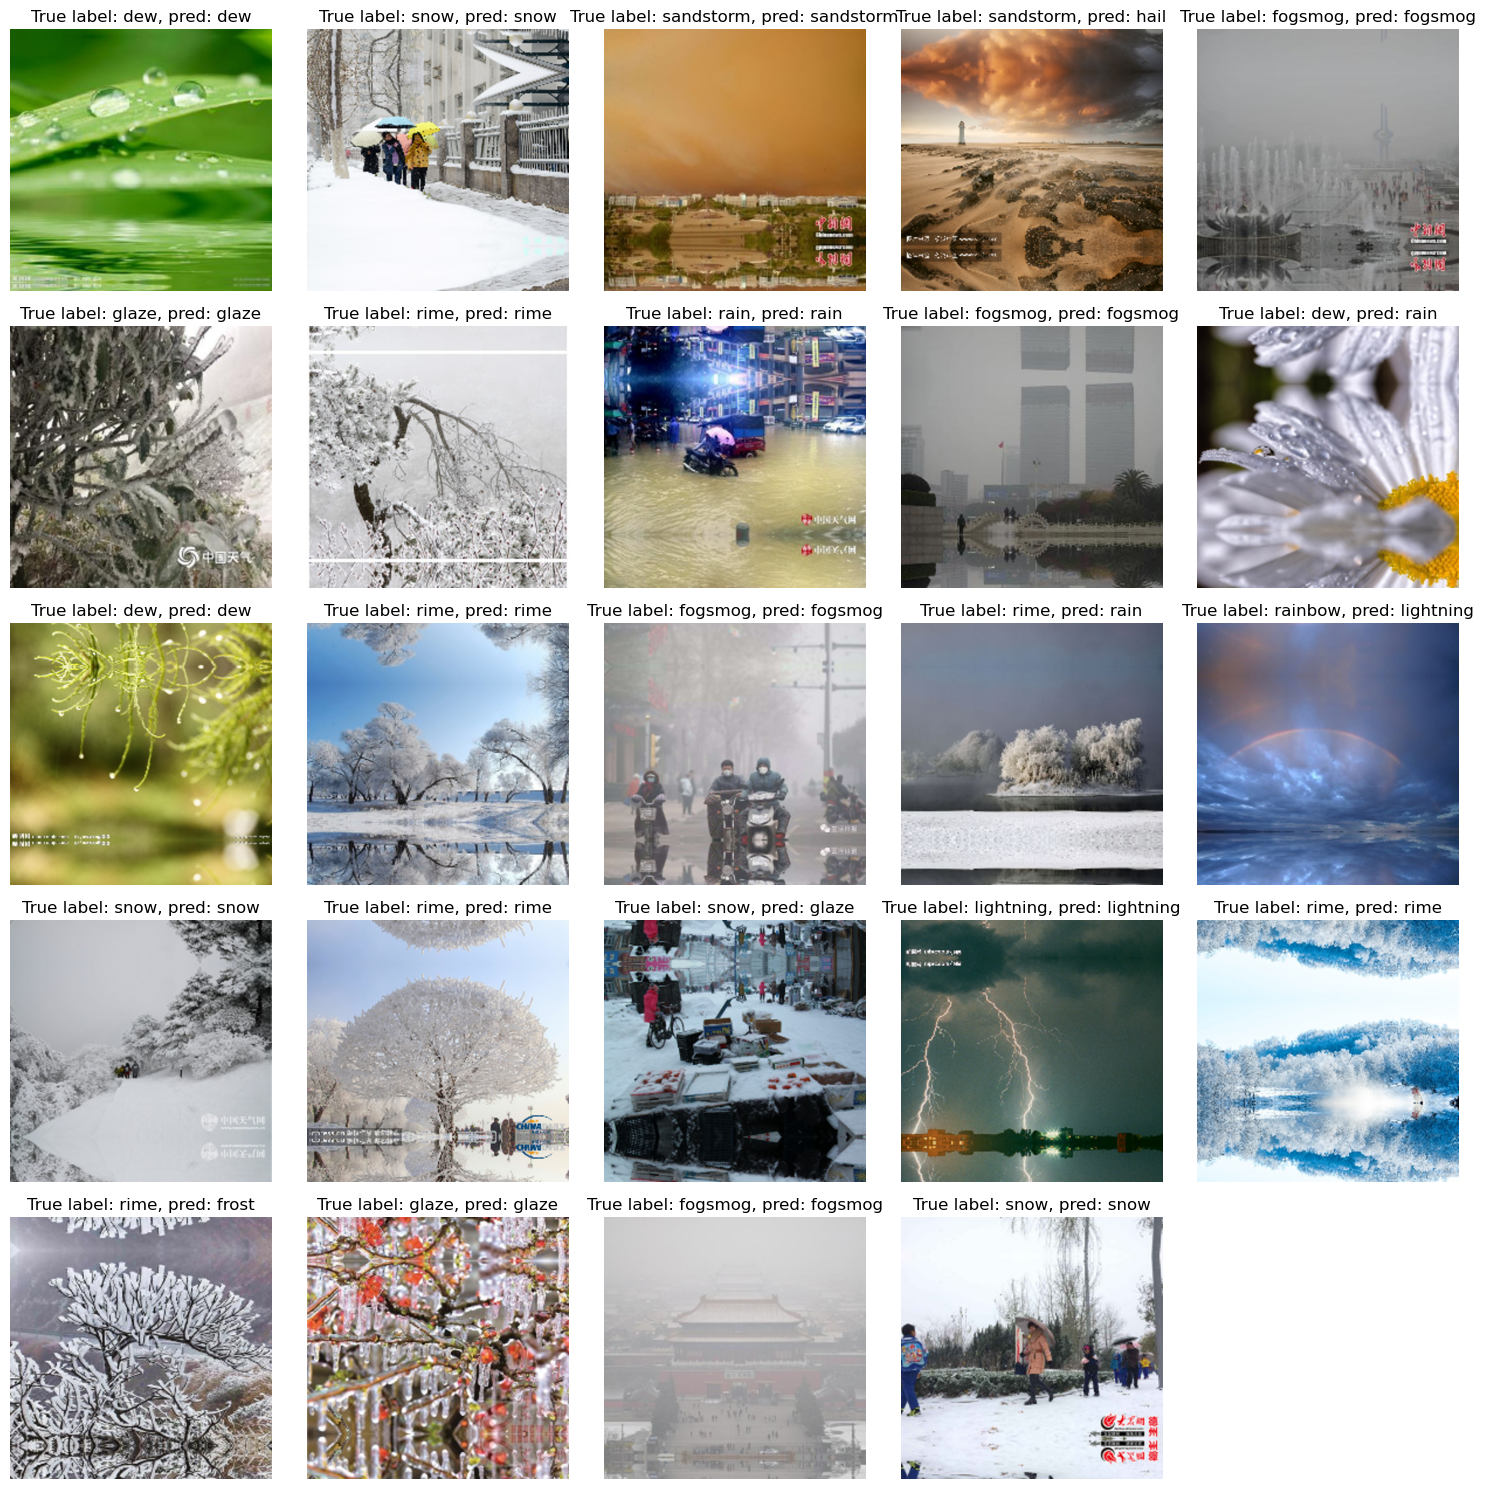

In [63]:
plot(num_images=24, model=model)